In [6]:
import riskparity
import mpt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import numpy as np
import pandas as pd
from utils import *
import matplotlib.pyplot as plt


# Tickers: list of asset tickers
# b: RRCs
# year_range_start: date to start from
# years: number of years in long run
def optimal_portfolio_returns(tickers, b, year_range_start, years, short_run_years):


    current_date = datetime.strptime(year_range_start, "%Y-%m-%d")
    start_date_for_data = (current_date - relativedelta(months = 25)).strftime("%Y-%m-%d")

    final_date, final_date_str = year(year_range_start, years)
    # print("CURRENT DATE:", year_range_start, "CURRENT DATE TYPE:", type(year_range_start))
    # print("FINAL DATE:", final_date_str, "FINAL DATE TYPE:", type(final_date_str))
    data = yf.download(tickers, start=start_date_for_data, end=final_date_str)["Close"]
    data = data.fillna(method='pad')
    data.to_excel('test.xlsx', index=False)

    market_data = yf.download("^GSPC", start=start_date_for_data, end=final_date_str)["Close"]

    # find total number of trading days 
    trading_days = get_trading_days(year_range_start, final_date_str)
    daily_rf_rate = 0.045 / trading_days # daily risk free rate


    # Loop through all short term periods, each 5 years on a 6 month sliding window basis
    x_axis_mpt = []
    y_axis_rp = []
    while current_date < final_date - relativedelta(days = 1): 

        end_date, _ = year(current_date, short_run_years)
        print("CURRENT WINDOW:", current_date, " - ", end_date)

        # MPT Portfolio
        sharpe = mpt.find_best_portfolio(data, market_data, daily_rf_rate, current_date, end_date)
        x_axis_mpt.append(sharpe)

        # Ex-Ante Risk Parity Portfolio
        # Loop through every month for 5 years
        current_ex_ante_date = current_date
        total_returns = 0
        total_variance = 0
        while current_ex_ante_date <= end_date and current_ex_ante_date < final_date - relativedelta(days = 32):
          # Use data from two years prior to make predictions
          _, two_years_prior_str = year(current_ex_ante_date, -2)
          end_ex_ante_date = current_ex_ante_date + relativedelta(months = 1)
          print("CURRENT EX-ANTE WINDOW:", current_ex_ante_date, " - ", end_ex_ante_date)
          # Get RRC weights using two years prior until now 
          rp_weights = riskparity.produce_rbp_stats(data, b, two_years_prior_str, current_ex_ante_date.strftime("%Y-%m-%d"))
          # print("WEIGHTS!!!!!", rp_weights)
          # Get returns for the month
          month_returns, month_variance =  mpt.portfolio_returns(current_ex_ante_date.strftime("%Y-%m-%d"), end_ex_ante_date.strftime("%Y-%m-%d"), data, rp_weights)
          total_variance += month_variance
          total_returns = ((1 + total_returns) * (1 + month_returns)) - 1
          current_ex_ante_date = current_ex_ante_date + relativedelta(months=1)

        volatility = total_variance**0.5
        risk_free_rate_st = (0.045 + 1)**short_run_years - 1
        rp_sharpe = (total_returns - risk_free_rate_st) / volatility
        print(total_returns, "-", risk_free_rate_st, "/", volatility, "=", rp_sharpe)
        y_axis_rp.append(float(rp_sharpe))
        current_date = current_date + relativedelta(months = 6)

    return x_axis_mpt, y_axis_rp



def rrc_score(x_axis_mpt, y_axis_rp):
  return np.sum((np.array(y_axis_rp)- np.array(x_axis_mpt))) / len(y_axis_rp)  

[*********************100%***********************]  2 of 2 completed

BBBBBBBB: [1 1]



C:\Users\jmacy\AppData\Local\Temp\ipykernel_28668\2154788065.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='pad')
[*********************100%***********************]  1 of 1 completed


CURRENT WINDOW: 2000-01-01 00:00:00  -  2001-01-01 00:00:00
CURRENT EX-ANTE WINDOW: 2000-01-01 00:00:00  -  2000-02-01 00:00:00
Optimized Weights: [0.47625521 0.52374479]
CURRENT EX-ANTE WINDOW: 2000-02-01 00:00:00  -  2000-03-01 00:00:00
Optimized Weights: [0.46933731 0.53066269]
CURRENT EX-ANTE WINDOW: 2000-03-01 00:00:00  -  2000-04-01 00:00:00
Optimized Weights: [0.46716022 0.53283978]
CURRENT EX-ANTE WINDOW: 2000-04-01 00:00:00  -  2000-05-01 00:00:00
Optimized Weights: [0.45927994 0.54072006]
CURRENT EX-ANTE WINDOW: 2000-05-01 00:00:00  -  2000-06-01 00:00:00
Optimized Weights: [0.45174164 0.54825836]
CURRENT EX-ANTE WINDOW: 2000-06-01 00:00:00  -  2000-07-01 00:00:00
Optimized Weights: [0.44841955 0.55158045]
CURRENT EX-ANTE WINDOW: 2000-07-01 00:00:00  -  2000-08-01 00:00:00
Optimized Weights: [0.44883919 0.55116081]
CURRENT EX-ANTE WINDOW: 2000-08-01 00:00:00  -  2000-09-01 00:00:00
Optimized Weights: [0.45072916 0.54927084]
CURRENT EX-ANTE WINDOW: 2000-09-01 00:00:00  -  2000

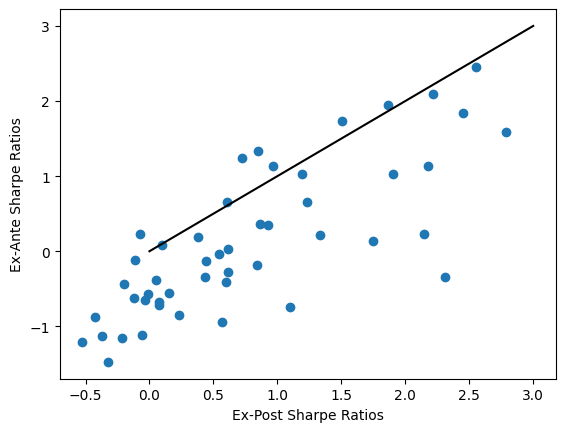

[*********************100%***********************]  2 of 2 completed

-0.6457211408342105
BBBBBBBB: [2 1]



C:\Users\jmacy\AppData\Local\Temp\ipykernel_28668\2154788065.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='pad')
[*********************100%***********************]  1 of 1 completed


CURRENT WINDOW: 2000-01-01 00:00:00  -  2001-01-01 00:00:00
CURRENT EX-ANTE WINDOW: 2000-01-01 00:00:00  -  2000-02-01 00:00:00
Optimized Weights: [0.5656381 0.4343619]
CURRENT EX-ANTE WINDOW: 2000-02-01 00:00:00  -  2000-03-01 00:00:00
Optimized Weights: [0.55800198 0.44199802]
CURRENT EX-ANTE WINDOW: 2000-03-01 00:00:00  -  2000-04-01 00:00:00
Optimized Weights: [0.55636342 0.44363658]
CURRENT EX-ANTE WINDOW: 2000-04-01 00:00:00  -  2000-05-01 00:00:00
Optimized Weights: [0.54836152 0.45163848]
CURRENT EX-ANTE WINDOW: 2000-05-01 00:00:00  -  2000-06-01 00:00:00
Optimized Weights: [0.54432303 0.45567697]
CURRENT EX-ANTE WINDOW: 2000-06-01 00:00:00  -  2000-07-01 00:00:00
Optimized Weights: [0.54053124 0.45946876]
CURRENT EX-ANTE WINDOW: 2000-07-01 00:00:00  -  2000-08-01 00:00:00
Optimized Weights: [0.53995196 0.46004804]
CURRENT EX-ANTE WINDOW: 2000-08-01 00:00:00  -  2000-09-01 00:00:00
Optimized Weights: [0.54132915 0.45867085]
CURRENT EX-ANTE WINDOW: 2000-09-01 00:00:00  -  2000-1

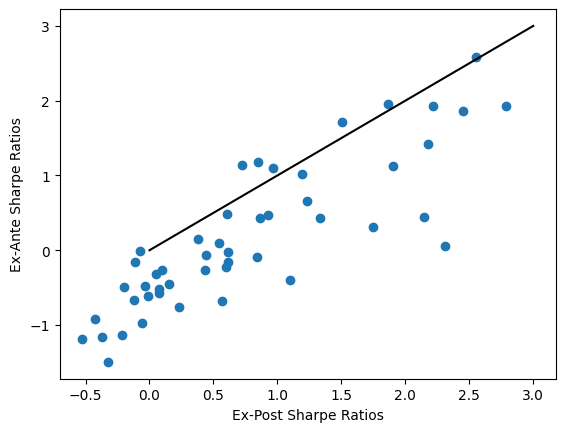

-0.5889397313681218
[-0.6457211408342105, -0.5889397313681218]
[0.5, 0.6666666666666666]
0


0.6666666666666666

In [ ]:
def get_the_macy_ratio():
  tickers = ["^GSPC", "^TNX"]
  b = np.array([1, 1])

  macy_constants = []
  scores = []
  for i in range(0, 40, 1):
    macy_interval = i / 20
    b[0] += macy_interval
    macy_constant = b[0] / (np.sum(b))
    print("BBBBBBBB:", b)
    macy_constants.append(float(macy_constant))

    
    # start_date="1980-01-01"
    start_date="2000-01-01"

    x_axis_mpt, y_axis_rp = optimal_portfolio_returns(tickers, b, start_date, 24, 1)

    plt.figure()
    plt.scatter(x_axis_mpt, y_axis_rp)
    x_line = np.linspace(0, 3, 10)  # Adjust range if needed
    plt.plot(x_line, x_line, color='black', label='y = x')
    plt.xlabel("Ex-Post Sharpe Ratios")
    plt.ylabel("Ex-Ante Sharpe Ratios")
    plt.show()

    score = rrc_score(x_axis_mpt, y_axis_rp)
    print(score)
    scores.append(float(score))
  
  print(scores)
  print(macy_constants)
  return float(macy_constants[np.argmax(scores)])

get_the_macy_ratio()
    
